In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
from astropy.constants import c
from scipy.fftpack import fft, fftfreq
c = c.value*1e-6 #Speed of light in mm/ns
from scipy.optimize import curve_fit
import matplotlib.mlab as mlab
import scipy.optimize as op
from random import gauss

In [3]:
T = 0.9763
R = 0.0234
A = 0.0003
L = 2.25*25.4
nu_fsr = c/(2*L)
print(nu_fsr)

2.62285615048119


In [7]:
min_x =  int(140/nu_fsr) + 1
max_x = min_x + 10
n = 2**12
x = np.linspace(min_x, max_x, n)
nu = x*nu_fsr
F = 4*R/(1-R)**2
x = nu/nu_fsr
delta = 2*np.pi*x
P_err = np.random.uniform(0.01, 0.03, n)
P = (T/(1-R))**2*1./(1 + F*np.sin(delta/2)**2)
noise = np.array(list(map(lambda i: gauss(0,P_err[i]), np.arange(n))))
P += noise



I will use the MLE models to fit an n-term fourier series to the FP fringes. 

The model in hand is described by:
$P(x) = a_0 + \sum\limits_{k=1}^n c_k \cos\left(2 \pi k x \right) + s_k \sin\left(2 \pi k x \right) $. Here $ x = \nu/\Delta \nu $ with $ \Delta \nu $ being the free spectral range is my independent variable. P(x) has a period of 1 in x. 

In [8]:
def transmissionModel(nu, *theta):
    # Fits for the first n terms of a fourier series for a period equal to 1.
    """
    Returns the n term fourier series expansion of a function which has a period of 1 in x and has the fourier
    coefficients listed in theta. The last component of theta is a the fundamental period of the oscillations.
    """
    assert (len(theta)%2)==0, "The length of theta must be even"
    n = len(theta)/2 - 1# Remember n isn't the length of the array.It is the number of terms in the fourier expansion.
#     b0 = theta[0]
#     c_k = theta[1:n+1] - to get n terms!!!!
#     s_k = theta[n+1:] - to get n terms!!!!
    # Lambda functions for each term in the fourier series
    fsr = theta[-1]
    c_k = theta[1:n+1]
    s_k = theta[n+1:-1]
    x = nu/fsr
    index = np.arange(1,n+1)
    fourier_cterm = lambda ck, k: ck*np.cos(2*np.pi*x*k)
    fourier_sterm = lambda sk, k: sk*np.sin(2*np.pi*x*k)
    
    return theta[0] + np.sum(map(fourier_cterm, c_k, index),axis=0)+\
    np.sum(map(fourier_sterm, s_k, index),axis=0)

def lnlike(theta, x, y, yerr):
    model = transmissionModel(x, *theta)
    inv_sigma2 = 1.0/(yerr**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2))

nll = lambda *args: -lnlike(*args)

In [9]:
# Let's first try and do an n term fit to the data above.
n = 3
k = np.arange(1,n+1)
phi_k = 2*np.pi*k*x[0]
b0 = np.average(P)
b_k = 2*R**k*b0
c_k = b_k*np.cos(2*np.pi*k*x[0])
s_k = b_k*np.sin(2*np.pi*k*x[0])
guesses = [b0] +list(c_k) + list(s_k) + [nu_fsr]
print(len(guesses))

8


In [17]:
P_2 = transmissionModel(nu, *guesses)
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(nu, P, 'b.', label='FP Model')
ax.plot(nu, P_2, 'r', label=r'%d term  Fourier Series'%n)
ax.axis('tight')
ax.set_xlabel('frequency [GHz]')
ax.set_ylabel('FP transmission Normalized');
ax.legend(loc='best')

# fig, ax = plt.subplots(figsize=(15,10))
# ax.plot(nu, error)  # Fourier Coefficients 
# ax.plot(max_nu, error[max_indices], 'rd', markersize=20, label='Maxima of FP')
# ax.plot(min_nu, error[min_indices], 'kd', markersize=20, label='Minima of FP')
# # ax.axis('tight')
# ax.set_xlabel('k')
# ax.set_yticklabels(['%1.2g' %t for t in ax.get_yticks()]);
# ax.set_ylabel('Error')
# ax.legend(loc='best')
# print np.average(error**2)**0.5
print(P_2[0])
print(P[0])

TypeError: slice indices must be integers or None or have an __index__ method

In [14]:
result = op.minimize(nll, guesses, args=(nu, P,P_err), method='Powell')
# print result['x']
print(result['message'])
chisq =  -2.0*lnlike(result['x'],x,\
             P,P_err)
print(chisq)
b0_MLE = result['x'][0]
bk_MLE = (result['x'][1:n+1]**2 + result['x'][n+1:-1]**2)**0.5
fsr_MLE = 2*np.pi/result['x'][-1]
print(fsr_MLE)

popt,pcov = curve_fit(transmissionModel,x,P,sigma=P_err, p0=guesses)
b0_cf = popt[0]
bk_cf = (popt[1:n+1]**2 + popt[n+1:-1]**2)**0.5
fsr_cf = 2*np.pi/popt[-1]

TypeError: slice indices must be integers or None or have an __index__ method

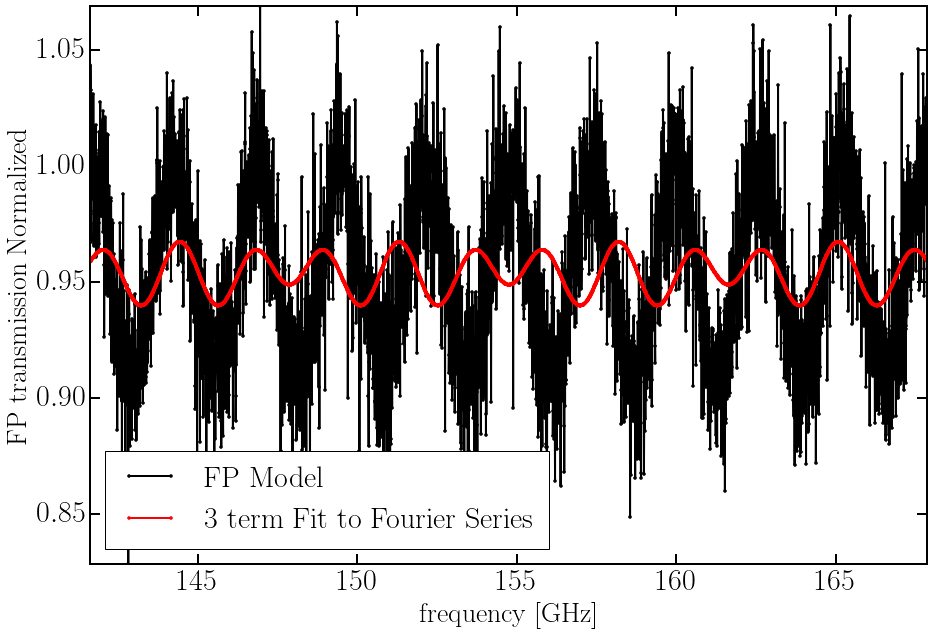

In [82]:
# P_fit = transmissionModel(x, *result['x'])
P_fit = transmissionModel(x, *popt)
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(nu, P, 'k.-', label='FP Model')
# ax.plot(nu, P_2, 'r', label=r'%d term  Fourier Series'%n)
ax.plot(nu, P_fit, 'r.-', label=r'%d term Fit to Fourier Series'%n)
ax.axis('tight')
ax.set_xlabel('frequency [GHz]')
ax.set_ylabel('FP transmission Normalized');
ax.legend(loc='best');

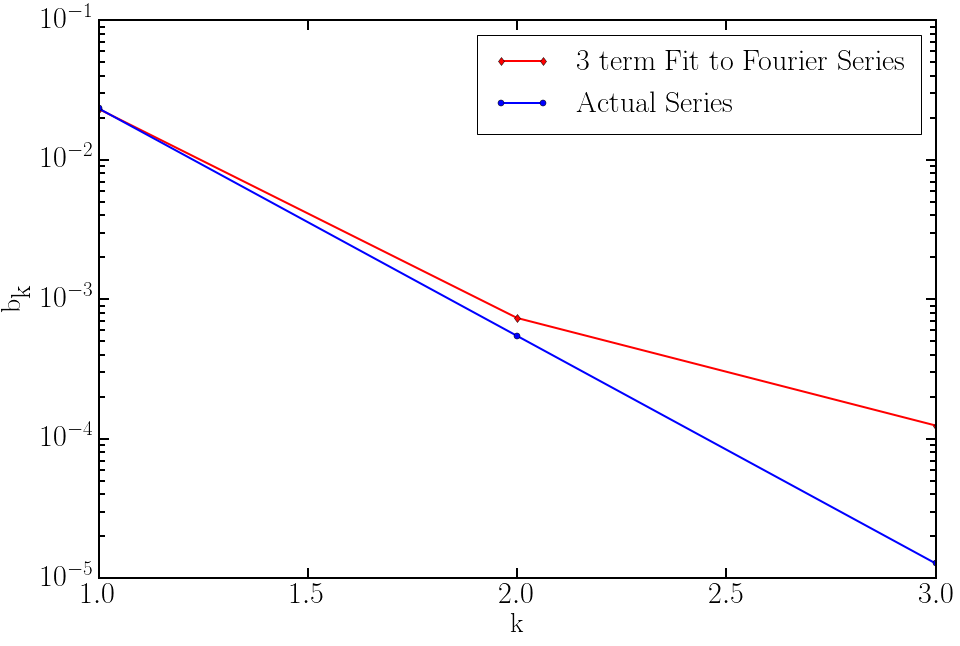

In [85]:
fig, ax = plt.subplots(figsize=(15,10))
ax.semilogy(k, bk_MLE/(2*b0_MLE),'rd-', label='%d term Fit to Fourier Series'%n)
ax.semilogy(k, R**k,'bo-', label = 'Actual Series')
ax.set_xlabel('k')
ax.legend(loc='best')
ax.set_ylabel(r'$\textrm{b}_{\textrm{k}}$');

In [77]:
# Implementing the Rayleigh Criterion for the data we have.
possible_freq = np.logspace(0,3,1000)
possible_fsr = 2*np.pi/possible_freq

N = len(nu)

def ray_criterion(w):
    return (np.sum(P*np.cos(w*nu))**2 + np.sum(P*np.sin(w*nu))**2)/N
    
Ray = np.array(map(ray_criterion, possible_freq))
ymin = min(Ray)
ymax = max(Ray)

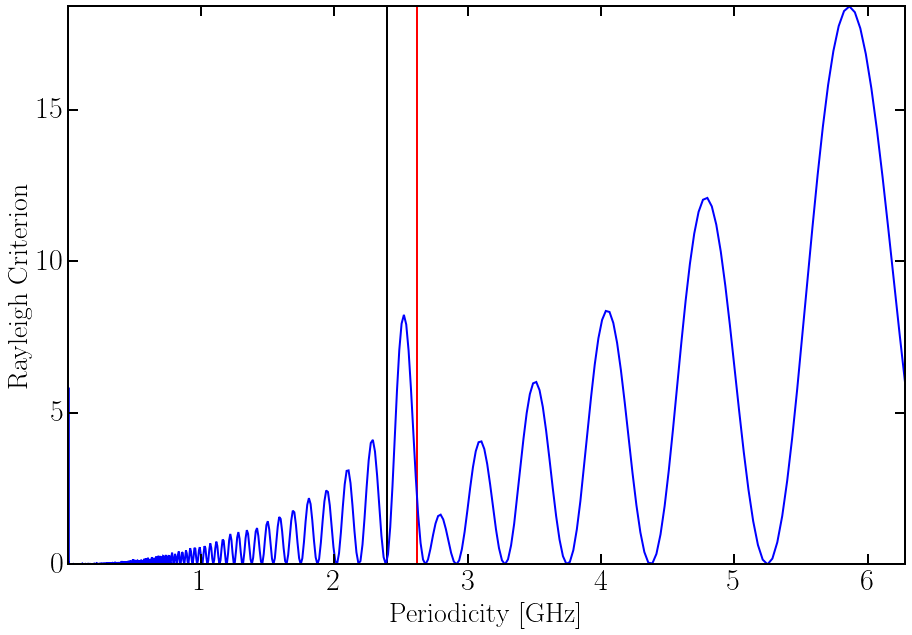

In [86]:
fig,ax = plt.subplots(figsize=(15,10))
ax.plot(possible_fsr, Ray)
ax.vlines(nu_fsr, ymin, ymax,'r')
ax.vlines(fsr_MLE, ymin, ymax,'k')
ax.set_xlabel(r'Periodicity [GHz]')
ax.set_ylabel('Rayleigh Criterion')
ax.axis('tight');

In [ ]:
ray_criterion((2*np.pi/(nu_fsr-0.0)))

In [ ]:
np.random.randn(10)

In [ ]:
np.random.uniform?